##### Summary
Socio-demographical and account activity data for 1615 bank clients were used for a data-driven marketing campaign. 60% of the 1615 clients have sales and revenue data while the remaining 40% do not. The remaining 40% serve as the target clients for this campaign. By training machine learning models, the campaign aims to predict the likelihood of a client to avail of a Mutual Fund (MF), a Credit Card (CC), or a Consumer Loan (CL). <br>

The dataset was preprocessed before model training. Label encoding for the Sex, finding and filling NaN values with zeros, and preparing the features and target subsets. A Logistic Regression model was used to predict the likelihood of a client to avail any of the three products. Afterwards, a Random Forest Regressor model was trained to predict per-client revenue given that they accept any of the three products. Both of these models had their hyperparameters tuned with Precision as the scoring metric. Precision was prefered over recall since we are limited to only contacting 100 clients. <br>

Two client lists were produced. The first list contains the top 100 likely buyers of any of the three products. The second list contains the top 100 clients with the highest expected revenue if ever they do purchase any of the three products. For the first list, the likelihood of purchase ranged from 51% to 99% while the expected revenue was €796 (with a maximum revenue of €1192 if all 100 clients purchase). For the second list, the likelihood of purchase ranged from 20% to 99% while the expected revenue was €930 (with a maximum revenue of €1864 if all 100 clients purchase). <br>

From the feature importances of the two models, we were able to infer which clients are likely to purchase a product, as well as which clients can potentially generate the most revenue. For potential MF buyers, they prefer cashless transactions and are disciplined spenders. For potential CC buyers, they have substantial savings and current account balances. Potential CL buyers, on the other hand, are young and loyal customers that are big spenders. <br>

In identifying high revenue clients, we found that MF clients which generated the most revenue were retired customers with high monthly credit turnovers. On the other hand, high revenue CC clients were either new or tenured, of retirement age, and have a number of current account debit transactions. Lastly, high revenue CL clients are either new or tenured, 20-50 years of age, and have large savings account balances. <br>

The final lists for clients are labeled: <br>
top_clients_likelihood_and_rev (top 100 likely buyers) <br>
max_revenue_clients (top 100 maximum expected revenue)

In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import squarify
import textwrap

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix,average_precision_score,precision_recall_curve, PrecisionRecallDisplay,root_mean_squared_error,mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.stats import randint, loguniform
from sklearn.inspection import PartialDependenceDisplay

## DATA PREPROCESSING

combining sheets, label encoding, checking for NaN and filling with 0s, checking for missing values, and preparing/dividing the dataset

In [3]:
# Loading raw data
Data = pd.ExcelFile('data.xlsx')

# Reading individual sheets into DataFrames
soc_dem = pd.read_excel(Data, sheet_name='Soc_Dem', index_col=0)
# Label encoding for binary categorical variables
soc_dem['Sex'] = soc_dem['Sex'].map({'M': 1, 'F': 0})

Products_ActBalance = pd.read_excel(Data, sheet_name='Products_ActBalance', index_col=0)
# NaN values were filled with 0
Products_ActBalance = Products_ActBalance.fillna(0) 

Inflow_Outflow = pd.read_excel(Data, sheet_name='Inflow_Outflow', index_col=0) # note: some clients missing
Sales_Revenues = pd.read_excel(Data, sheet_name='Sales_Revenues', index_col=0) # note: only 60% of all clients

data_without_sales = pd.concat([soc_dem, Products_ActBalance, Inflow_Outflow], axis=1)
test_set_data = pd.concat([data_without_sales.loc[Sales_Revenues.index], Sales_Revenues], axis=1) # 60% of data, for modelling

In [4]:
features = data_without_sales.loc[Sales_Revenues.index]
features = features.fillna(0)  
# targets
labels_mf = Sales_Revenues.iloc[:,0]
labels_cc = Sales_Revenues.iloc[:,1]  
labels_cl = Sales_Revenues.iloc[:,2]  

X_temp_mf, X_finaltest_mf, y_temp_mf, y_finaltest_mf = train_test_split(features, labels_mf, test_size=0.2, random_state=42, stratify=labels_mf)
X_train_mf, X_test_mf, y_train_mf, y_test_mf = train_test_split(X_temp_mf, y_temp_mf, test_size=0.25, random_state=42, stratify=y_temp_mf)

X_temp_cc, X_finaltest_cc, y_temp_cc, y_finaltest_cc = train_test_split(features, labels_cc, test_size=0.2, random_state=42, stratify=labels_cc)
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_temp_cc, y_temp_cc, test_size=0.25, random_state=42, stratify=y_temp_cc)

X_temp_cl, X_finaltest_cl, y_temp_cl, y_finaltest_cl = train_test_split(features, labels_cl, test_size=0.2, random_state=42, stratify=labels_cl)
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_temp_cl, y_temp_cl, test_size=0.25, random_state=42, stratify=y_temp_cl)

DATASET INFORMATION:

\# of clients: 1615 (100%) <br>
\# of clients with sales and revenue data (for modelling): 969 (60%)  <br>
\# of clients without data (for predicting): 646 (40%) <br>

\# of clients for training: 581 (60% of modeling data) <br>
\# of clients for testing: 194 (20%) <br>
\# of clients for validation: 194 (20%) <br>


In [5]:
# clients to predict
features_unlabeled = data_without_sales.drop(Sales_Revenues.index, axis=0)
features_unlabeled.isna().sum()  # Check for NaN values in the unlabeled data
features_unlabeled = features_unlabeled.fillna(0)  # Fill NaN values with 0
features_unlabeled

,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
Client,,,,,,,,,,,,,,,,,,,,,
3,1.0,17,140,1,0.0,1.0,0.0,0.0,0.0,482.654643,...,123.750000,123.750000,0.000000,112.857143,10.678571,3.0,3.0,0.0,1.0,1.0
4,1.0,24,153,1,1.0,0.0,0.0,1.0,0.0,1599.840714,...,3614.747500,3598.950357,714.285714,526.037500,1963.165357,41.0,36.0,6.0,12.0,13.0
5,0.0,58,200,1,1.0,0.0,0.0,0.0,0.0,5353.483929,...,5868.460714,4031.925000,157.142857,832.175000,1779.571429,44.0,41.0,4.0,17.0,13.0
7,0.0,55,227,1,0.0,0.0,0.0,0.0,0.0,879.685000,...,99.043929,99.043929,17.857143,69.151071,10.714286,10.0,10.0,1.0,6.0,1.0
9,0.0,33,182,1,0.0,0.0,1.0,0.0,0.0,510.166429,...,415.460714,375.705357,53.571429,0.000000,170.714286,10.0,7.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,1.0,47,78,1,0.0,0.0,0.0,0.0,1.0,2366.576786,...,589.663214,580.484643,0.000000,129.318214,219.642857,19.0,17.0,0.0,7.0,5.0
1609,1.0,31,111,1,0.0,0.0,0.0,0.0,0.0,206.872143,...,92.928571,92.928571,0.000000,0.000000,92.928571,2.0,2.0,0.0,0.0,2.0
1610,0.0,48,92,1,0.0,0.0,1.0,0.0,0.0,196.544286,...,2769.281071,2731.959643,196.428571,43.889286,169.321429,20.0,18.0,3.0,2.0,7.0


In [6]:
#for plotting
def plot_confusion_matrix(y_true, y_pred, label_name, normalize=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    if normalize:
        plt.title(f'Normalized Confusion Matrix for {label_name}')
    plt.title(f'Confusion Matrix for {label_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_pr_curve(pipe,x_te,y_te):
    
    proba = pipe.predict_proba(x_te)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_te, proba)

    disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
    disp.plot()
    plt.title("Precision–Recall Curve")
    plt.show()


## models to predict which client is likely to accept offer <br> 
we try logistic regression and random forest classifier and see which one performs better

### logistic regression

In [7]:
def tune_lr_params(X_tr, y_tr, balance, n_iter=20, cv_folds=5):
    """
    Runs RandomizedSearchCV to find best hyperparameters for Logistic Regression.
    Returns cleaned dict of LR args and best CV precision.
    """
    # pipeline
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf",   LogisticRegression(
                      random_state=42,
                      class_weight='balanced' if balance else None
                    #   max_iter=100
                  ))
    ])
    # C to check
    param_dist = {
        "clf__C":            loguniform(1e-4, 1e2),       # 0.0001 - 100
        "clf__penalty":      ["l2"],
        "clf__max_iter":     [1,10,100,1000]                            
    }
    
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="precision",
        cv=StratifiedKFold(cv_folds, shuffle=True, random_state=42),
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_tr, y_tr)
    
    # results
    best = {
        key.replace("clf__", ""): val 
        for key, val in search.best_params_.items()
    }
    return best, search.best_score_

In [8]:
def evaluate_lr(X_tr, y_tr, X_te, y_te, label_name, cutoff, balance, reduced, tune):

    """ Evaluates a Logistic Regression model on the provided training and testing data.
    Parameters:
    - X_tr: Training features
    - y_tr: Training labels
    - X_te: Testing features
    - y_te: Testing labels
    - label_name: Name of the product label for reporting
    - cutoff: Probability threshold for classification (default is 0.35)

    Returns:
    - pipe: The fitted pipeline containing the scaler and classifier
    - lr_data: DataFrame containing precision, recall, and f1-score for each class
    - coefs: Series containing the absolute coefficients of the features
    """
    if tune:
        best_params, best_score = tune_lr_params(X_tr, y_tr, balance)
        print(f"Tuned LR params: {best_params}, CV precision={best_score:.3f}")
    else:
        best_params = {}

    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf",   LogisticRegression(
                      C=best_params.get("C", 1.0),
                      penalty=best_params.get("penalty", "l2"),
                      solver="lbfgs",
                      max_iter=2000,
                      class_weight='balanced' if balance else None,
                      random_state=42
                  ))
    ])

    pipe.fit(X_tr, y_tr)
    proba_pos = pipe.predict_proba(X_te)[:, 1]
    y_pred = (proba_pos >= cutoff).astype(int)
    
    mode = "BALANCED" if balance else "UNBALANCED"
    size = "REDUCED"  if reduced else "FULL"
    print(f"\n{size} FEATURES AND {mode} LR {label_name} with CUTOFF {cutoff}:")

    print(classification_report(y_te, y_pred, digits=4))
    lr_data = classification_report(y_te, y_pred, digits=4, output_dict=True)
    lr_data = pd.DataFrame(lr_data).loc[['precision', 'recall', 'f1-score'], ['0', '1']]

    ap = average_precision_score(y_te, proba_pos)
    print(f"\n P-R AUC for {size} FEATURES AND {mode} LR {label_name} with CUTOFF {cutoff}: {ap:.4f}") 
    plot_confusion_matrix(y_te, y_pred, label_name)

    # 5) Feature Importance
    lr_step = pipe.named_steps['clf']      # grab the LogisticRegression instance
    coefs = pd.Series(
        abs(lr_step.coef_[0]), 
        index=X_tr.columns
    ).sort_values(ascending=True)
    
    return pipe, lr_data, coefs

In [9]:
def reduced_features(X_tr, y_tr, X_te, y_te, label_name, feats, cutoff, balance, tune):
    drop = 10 # arbitrary
    bottom = feats.head(drop).index.tolist()

    X_tr_reduced = X_tr.drop(columns=bottom)
    X_te_reduced = X_te.drop(columns=bottom)
    
    #rerun
    lr_reduced, lr_reduced_data, lr_reduced_coefs = evaluate_lr(
        X_tr_reduced, y_train_mf, 
        X_te_reduced, y_test_mf, 
        label_name + " (reduced)", cutoff, balance, reduced = True, tune=tune
    )
    return lr_reduced, lr_reduced_data, lr_reduced_coefs, X_te_reduced

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\jed jerrel escaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Tuned LR params: {'C': 1.7718847354806815, 'max_iter': 10, 'penalty': 'l2'}, CV precision=0.638

FULL FEATURES AND UNBALANCED LR MF with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8128    0.9806    0.8889       155
           1     0.5714    0.1026    0.1739        39

    accuracy                         0.8041       194
   macro avg     0.6921    0.5416    0.5314       194
weighted avg     0.7643    0.8041    0.7452       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR MF with CUTOFF 0.5: 0.3083


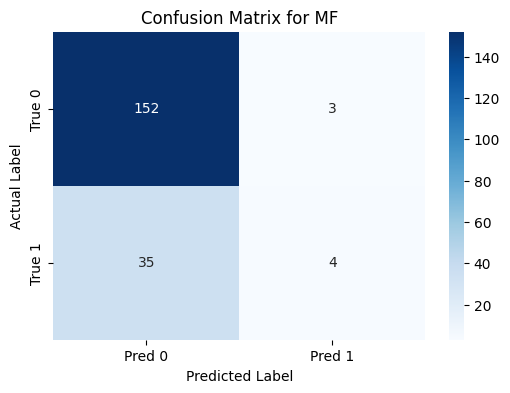


FULL FEATURES AND UNBALANCED LR MF with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8085    0.9806    0.8863       155
           1     0.5000    0.0769    0.1333        39

    accuracy                         0.7990       194
   macro avg     0.6543    0.5288    0.5098       194
weighted avg     0.7465    0.7990    0.7349       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR MF with CUTOFF 0.5: 0.3049


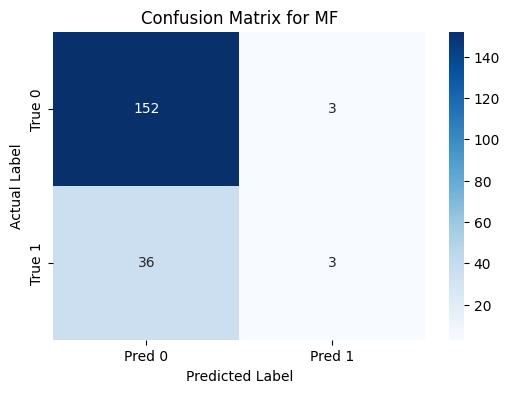

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.14081468939305825, 'max_iter': 100, 'penalty': 'l2'}, CV precision=0.601

FULL FEATURES AND UNBALANCED LR CC with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7772    0.9862    0.8693       145
           1     0.8000    0.1633    0.2712        49

    accuracy                         0.7784       194
   macro avg     0.7886    0.5747    0.5702       194
weighted avg     0.7829    0.7784    0.7182       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR CC with CUTOFF 0.5: 0.5388


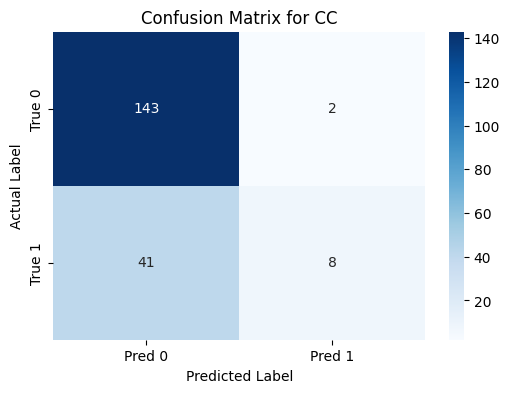


FULL FEATURES AND UNBALANCED LR CC with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7772    0.9862    0.8693       145
           1     0.8000    0.1633    0.2712        49

    accuracy                         0.7784       194
   macro avg     0.7886    0.5747    0.5702       194
weighted avg     0.7829    0.7784    0.7182       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR CC with CUTOFF 0.5: 0.5332


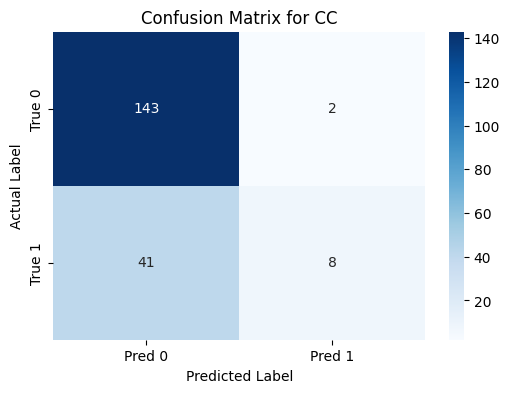

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.04731474644815004, 'max_iter': 100, 'penalty': 'l2'}, CV precision=0.728

FULL FEATURES AND UNBALANCED LR CL with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7308    0.9779    0.8365       136
           1     0.7500    0.1552    0.2571        58

    accuracy                         0.7320       194
   macro avg     0.7404    0.5666    0.5468       194
weighted avg     0.7365    0.7320    0.6633       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR CL with CUTOFF 0.5: 0.4974


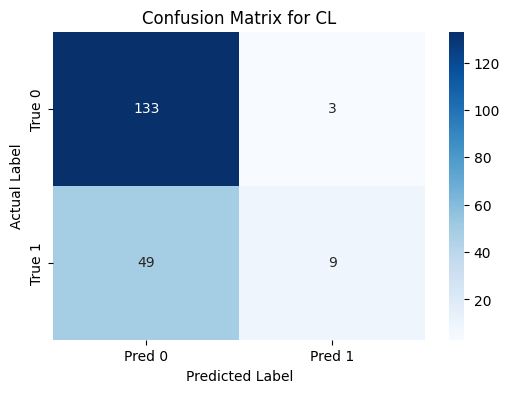


FULL FEATURES AND UNBALANCED LR CL with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7356    0.9412    0.8258       136
           1     0.6000    0.2069    0.3077        58

    accuracy                         0.7216       194
   macro avg     0.6678    0.5740    0.5667       194
weighted avg     0.6951    0.7216    0.6709       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR CL with CUTOFF 0.5: 0.4751


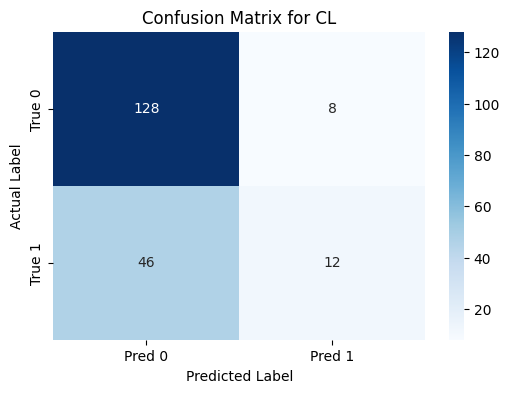

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.5132347525675524, 'max_iter': 1000, 'penalty': 'l2'}, CV precision=0.304

FULL FEATURES AND BALANCED LR MF with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8304    0.6000    0.6966       155
           1     0.2439    0.5128    0.3306        39

    accuracy                         0.5825       194
   macro avg     0.5371    0.5564    0.5136       194
weighted avg     0.7125    0.5825    0.6230       194


 P-R AUC for FULL FEATURES AND BALANCED LR MF with CUTOFF 0.5: 0.2861


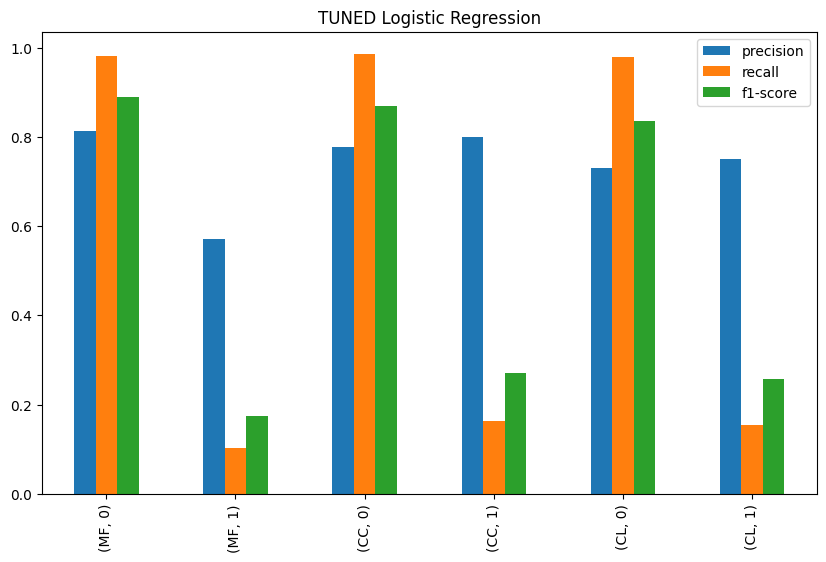

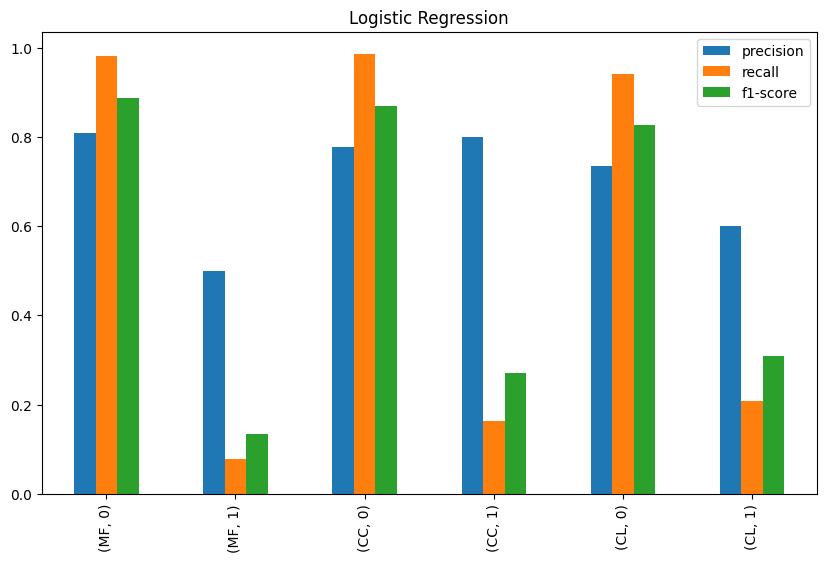

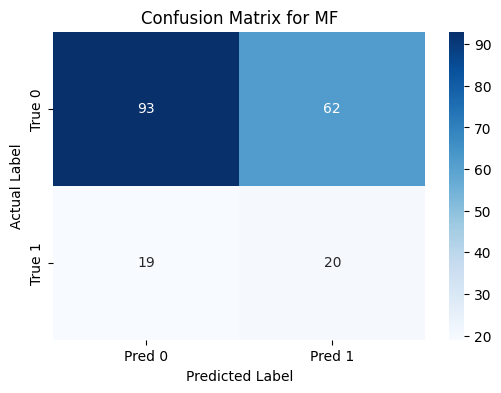


FULL FEATURES AND BALANCED LR MF with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8364    0.5935    0.6943       155
           1     0.2500    0.5385    0.3415        39

    accuracy                         0.5825       194
   macro avg     0.5432    0.5660    0.5179       194
weighted avg     0.7185    0.5825    0.6234       194


 P-R AUC for FULL FEATURES AND BALANCED LR MF with CUTOFF 0.5: 0.2883


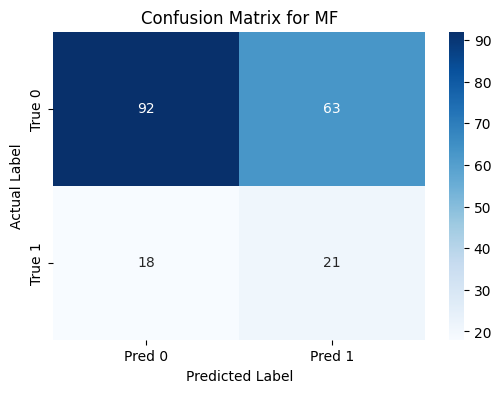

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.04731474644815004, 'max_iter': 100, 'penalty': 'l2'}, CV precision=0.360

FULL FEATURES AND BALANCED LR CC with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8190    0.6552    0.7280       145
           1     0.3590    0.5714    0.4409        49

    accuracy                         0.6340       194
   macro avg     0.5890    0.6133    0.5845       194
weighted avg     0.7028    0.6340    0.6555       194


 P-R AUC for FULL FEATURES AND BALANCED LR CC with CUTOFF 0.5: 0.5450


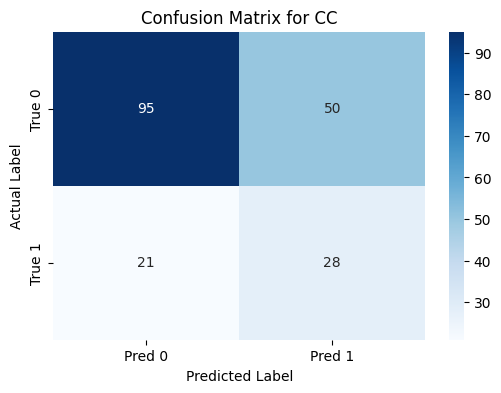


FULL FEATURES AND BALANCED LR CC with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8376    0.6759    0.7481       145
           1     0.3896    0.6122    0.4762        49

    accuracy                         0.6598       194
   macro avg     0.6136    0.6441    0.6121       194
weighted avg     0.7245    0.6598    0.6794       194


 P-R AUC for FULL FEATURES AND BALANCED LR CC with CUTOFF 0.5: 0.5220


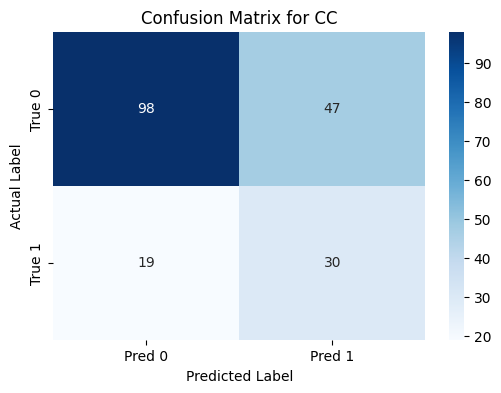

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.390796715682288, 'max_iter': 100, 'penalty': 'l2'}, CV precision=0.443

FULL FEATURES AND BALANCED LR CL with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7632    0.6397    0.6960       136
           1     0.3875    0.5345    0.4493        58

    accuracy                         0.6082       194
   macro avg     0.5753    0.5871    0.5726       194
weighted avg     0.6508    0.6082    0.6222       194


 P-R AUC for FULL FEATURES AND BALANCED LR CL with CUTOFF 0.5: 0.4668


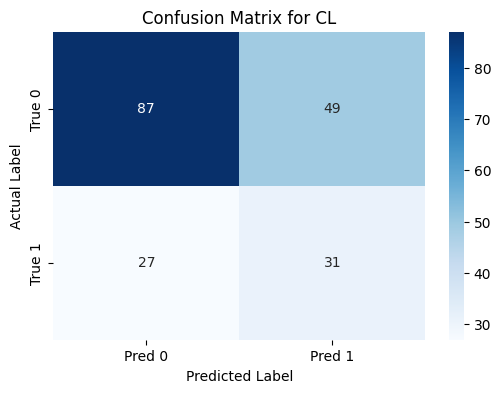


FULL FEATURES AND BALANCED LR CL with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7632    0.6397    0.6960       136
           1     0.3875    0.5345    0.4493        58

    accuracy                         0.6082       194
   macro avg     0.5753    0.5871    0.5726       194
weighted avg     0.6508    0.6082    0.6222       194


 P-R AUC for FULL FEATURES AND BALANCED LR CL with CUTOFF 0.5: 0.4607


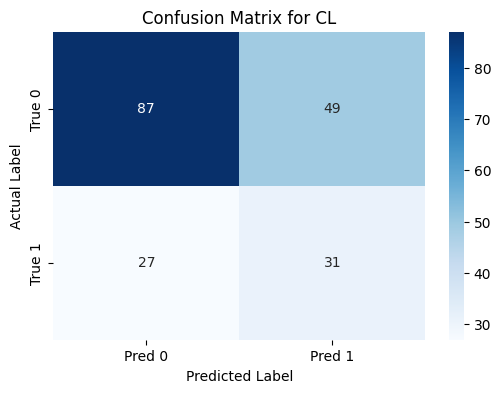

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\jed jerrel escaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Tuned LR params: {'C': 1.7718847354806815, 'max_iter': 10, 'penalty': 'l2'}, CV precision=0.617

REDUCED FEATURES AND UNBALANCED LR MF (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8075    0.9742    0.8830       155
           1     0.4286    0.0769    0.1304        39

    accuracy                         0.7938       194
   macro avg     0.6180    0.5256    0.5067       194
weighted avg     0.7313    0.7938    0.7317       194


 P-R AUC for REDUCED FEATURES AND UNBALANCED LR MF (reduced) with CUTOFF 0.5: 0.3314


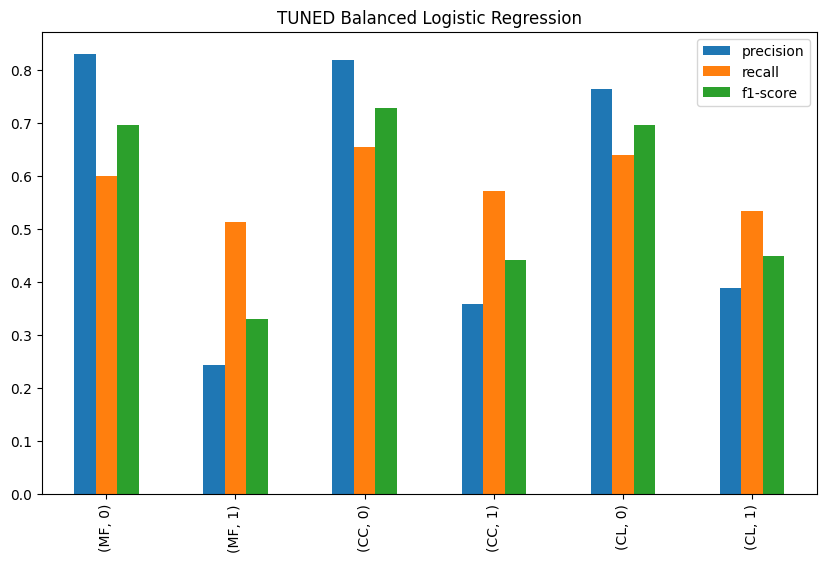

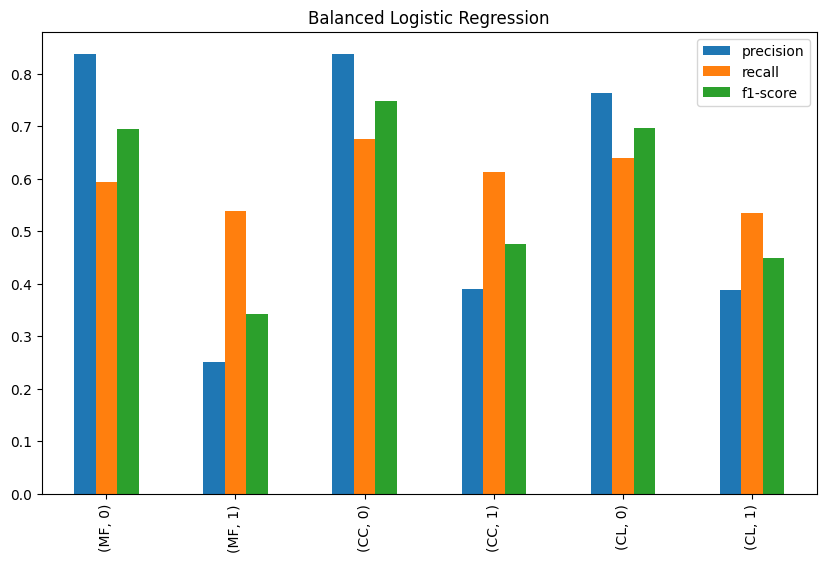

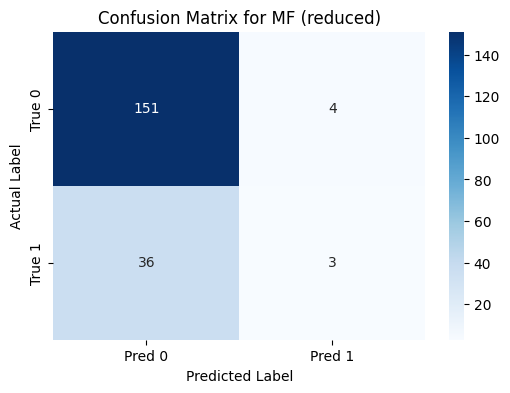


REDUCED FEATURES AND UNBALANCED LR MF (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8032    0.9742    0.8805       155
           1     0.3333    0.0513    0.0889        39

    accuracy                         0.7887       194
   macro avg     0.5683    0.5127    0.4847       194
weighted avg     0.7087    0.7887    0.7213       194


 P-R AUC for REDUCED FEATURES AND UNBALANCED LR MF (reduced) with CUTOFF 0.5: 0.3004


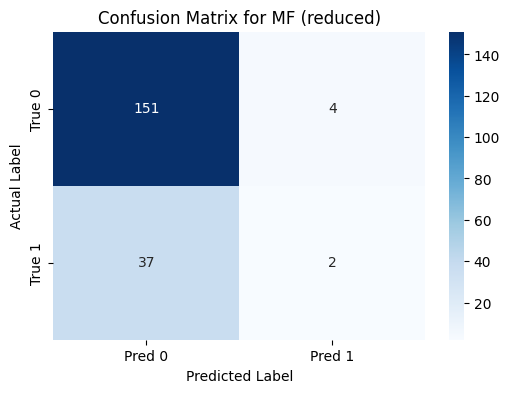

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.010051981180656776, 'max_iter': 1000, 'penalty': 'l2'}, CV precision=0.300

REDUCED FEATURES AND UNBALANCED LR CC (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7979    0.9935    0.8851       155
           1     0.0000    0.0000    0.0000        39

    accuracy                         0.7938       194
   macro avg     0.3990    0.4968    0.4425       194
weighted avg     0.6375    0.7938    0.7071       194


 P-R AUC for REDUCED FEATURES AND UNBALANCED LR CC (reduced) with CUTOFF 0.5: 0.1827


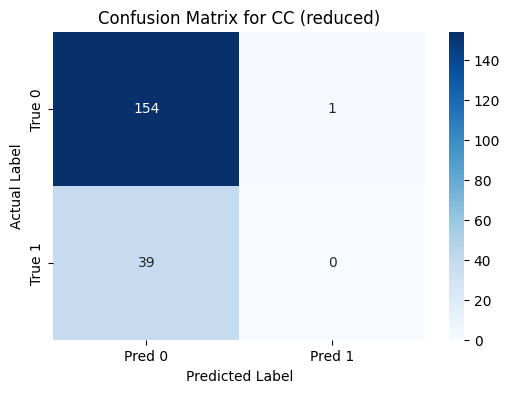


REDUCED FEATURES AND UNBALANCED LR CC (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8010    0.9871    0.8844       155
           1     0.3333    0.0256    0.0476        39

    accuracy                         0.7938       194
   macro avg     0.5672    0.5064    0.4660       194
weighted avg     0.7070    0.7938    0.7162       194


 P-R AUC for REDUCED FEATURES AND UNBALANCED LR CC (reduced) with CUTOFF 0.5: 0.2171


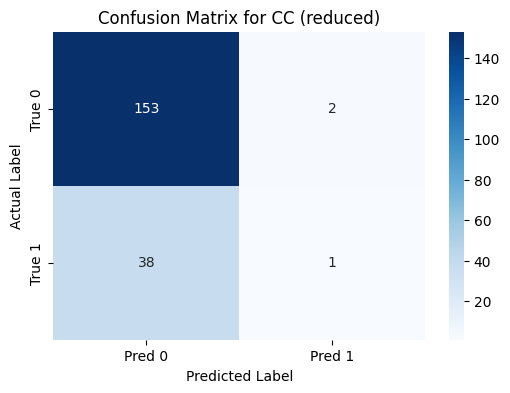

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\jed jerrel escaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jed jerrel escaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jed jerrel escaran\AppData\Local\Programs\Python\Python311\Lib\site-pac

Tuned LR params: {'C': 0.017670169402947945, 'max_iter': 1, 'penalty': 'l2'}, CV precision=0.200

REDUCED FEATURES AND UNBALANCED LR CL (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7990    1.0000    0.8883       155
           1     0.0000    0.0000    0.0000        39

    accuracy                         0.7990       194
   macro avg     0.3995    0.5000    0.4441       194
weighted avg     0.6384    0.7990    0.7097       194


 P-R AUC for REDUCED FEATURES AND UNBALANCED LR CL (reduced) with CUTOFF 0.5: 0.2741


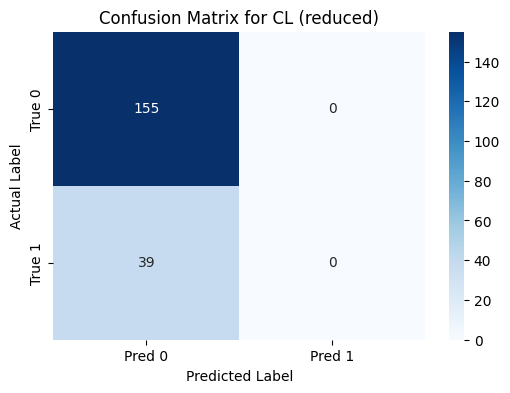


REDUCED FEATURES AND UNBALANCED LR CL (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7979    0.9935    0.8851       155
           1     0.0000    0.0000    0.0000        39

    accuracy                         0.7938       194
   macro avg     0.3990    0.4968    0.4425       194
weighted avg     0.6375    0.7938    0.7071       194


 P-R AUC for REDUCED FEATURES AND UNBALANCED LR CL (reduced) with CUTOFF 0.5: 0.2659


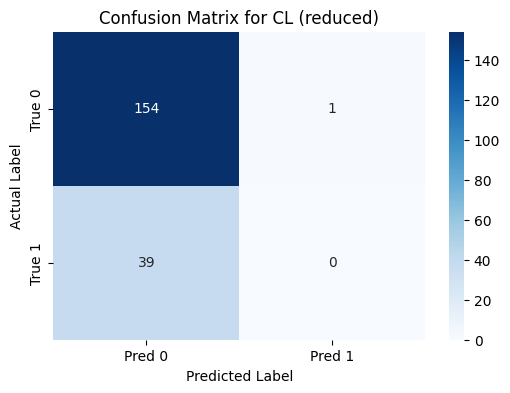

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.05450293694558251, 'max_iter': 100, 'penalty': 'l2'}, CV precision=0.321

REDUCED FEATURES AND BALANCED LR MF (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8208    0.5613    0.6667       155
           1     0.2273    0.5128    0.3150        39

    accuracy                         0.5515       194
   macro avg     0.5240    0.5371    0.4908       194
weighted avg     0.7014    0.5515    0.5960       194


 P-R AUC for REDUCED FEATURES AND BALANCED LR MF (reduced) with CUTOFF 0.5: 0.2474


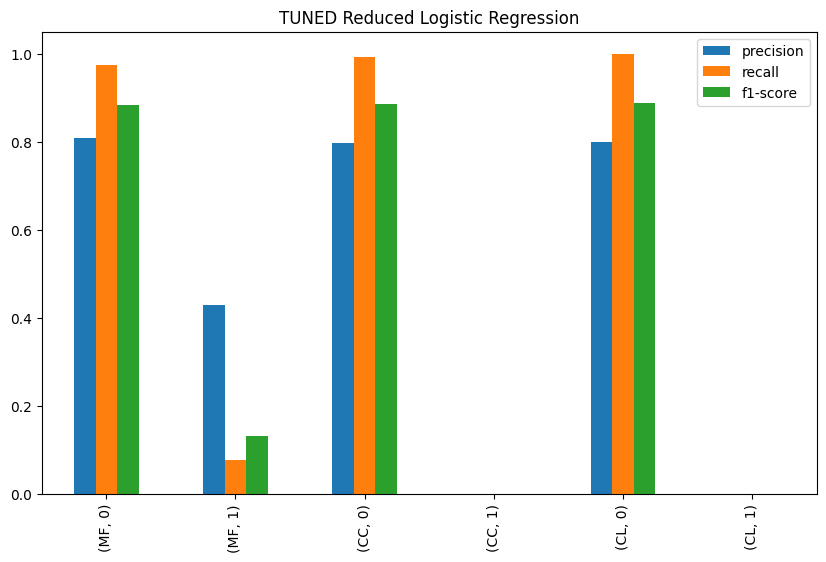

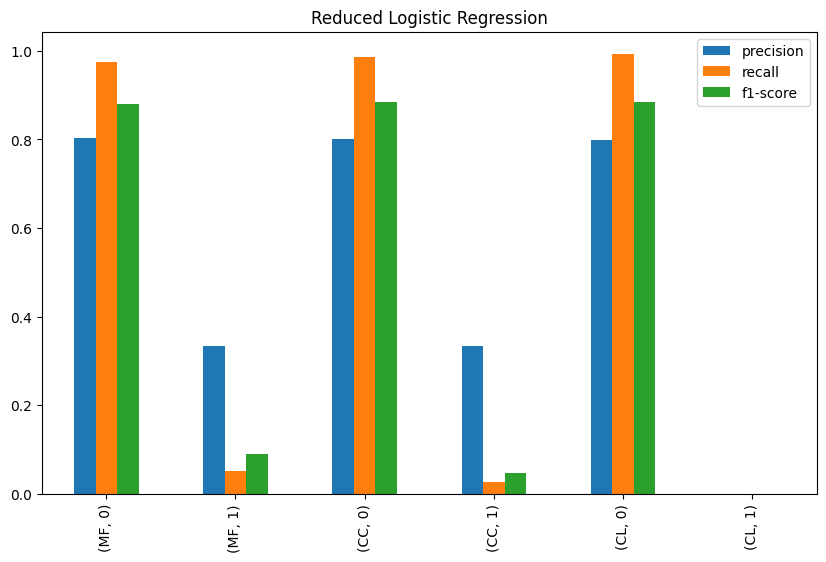

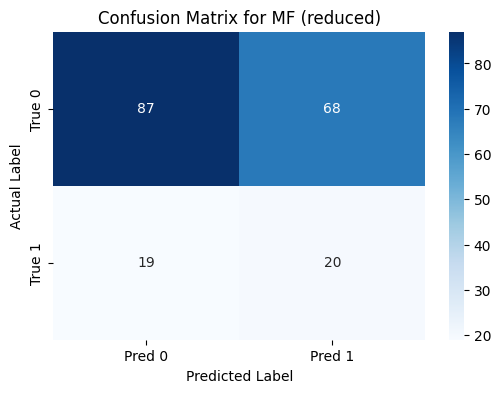


REDUCED FEATURES AND BALANCED LR MF (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8641    0.5742    0.6899       155
           1     0.2747    0.6410    0.3846        39

    accuracy                         0.5876       194
   macro avg     0.5694    0.6076    0.5373       194
weighted avg     0.7456    0.5876    0.6285       194


 P-R AUC for REDUCED FEATURES AND BALANCED LR MF (reduced) with CUTOFF 0.5: 0.2721


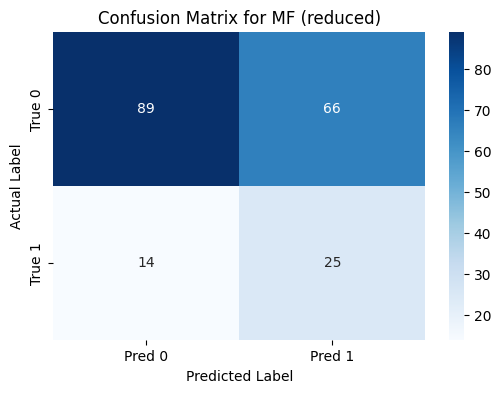

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\jed jerrel escaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Tuned LR params: {'C': 9.877700294007912, 'max_iter': 10, 'penalty': 'l2'}, CV precision=0.206

REDUCED FEATURES AND BALANCED LR CC (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7797    0.5935    0.6740       155
           1     0.1711    0.3333    0.2261        39

    accuracy                         0.5412       194
   macro avg     0.4754    0.4634    0.4500       194
weighted avg     0.6573    0.5412    0.5839       194


 P-R AUC for REDUCED FEATURES AND BALANCED LR CC (reduced) with CUTOFF 0.5: 0.2090


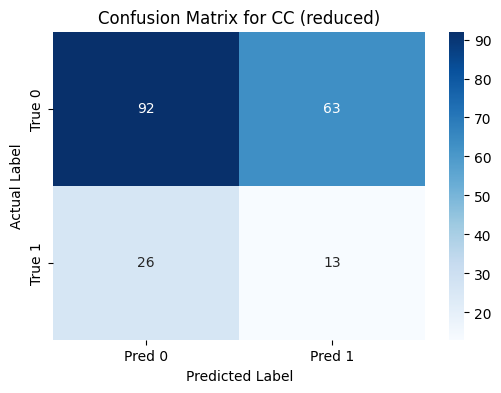


REDUCED FEATURES AND BALANCED LR CC (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7857    0.5677    0.6592       155
           1     0.1829    0.3846    0.2479        39

    accuracy                         0.5309       194
   macro avg     0.4843    0.4762    0.4536       194
weighted avg     0.6645    0.5309    0.5765       194


 P-R AUC for REDUCED FEATURES AND BALANCED LR CC (reduced) with CUTOFF 0.5: 0.2046


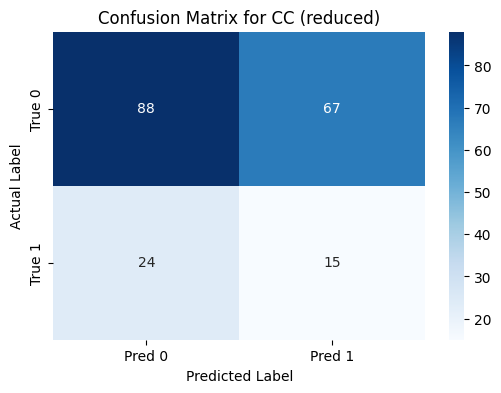

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.0012606912518374066, 'max_iter': 1000, 'penalty': 'l2'}, CV precision=0.204

REDUCED FEATURES AND BALANCED LR CL (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8258    0.7032    0.7596       155
           1     0.2581    0.4103    0.3168        39

    accuracy                         0.6443       194
   macro avg     0.5419    0.5567    0.5382       194
weighted avg     0.7116    0.6443    0.6706       194


 P-R AUC for REDUCED FEATURES AND BALANCED LR CL (reduced) with CUTOFF 0.5: 0.2859


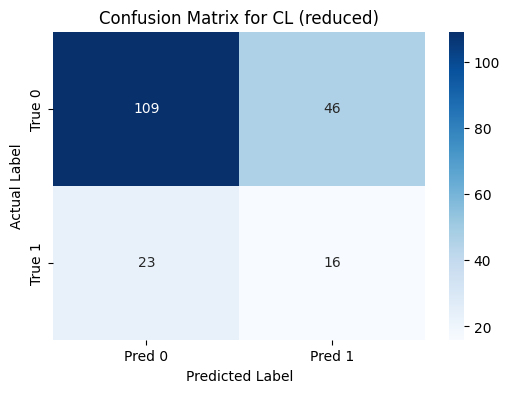


REDUCED FEATURES AND BALANCED LR CL (reduced) with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8365    0.5613    0.6718       155
           1     0.2444    0.5641    0.3411        39

    accuracy                         0.5619       194
   macro avg     0.5405    0.5627    0.5064       194
weighted avg     0.7175    0.5619    0.6053       194


 P-R AUC for REDUCED FEATURES AND BALANCED LR CL (reduced) with CUTOFF 0.5: 0.2672


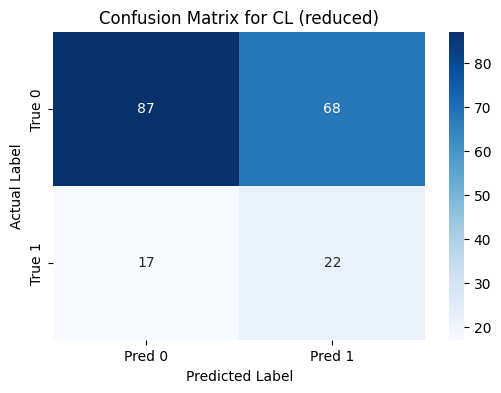

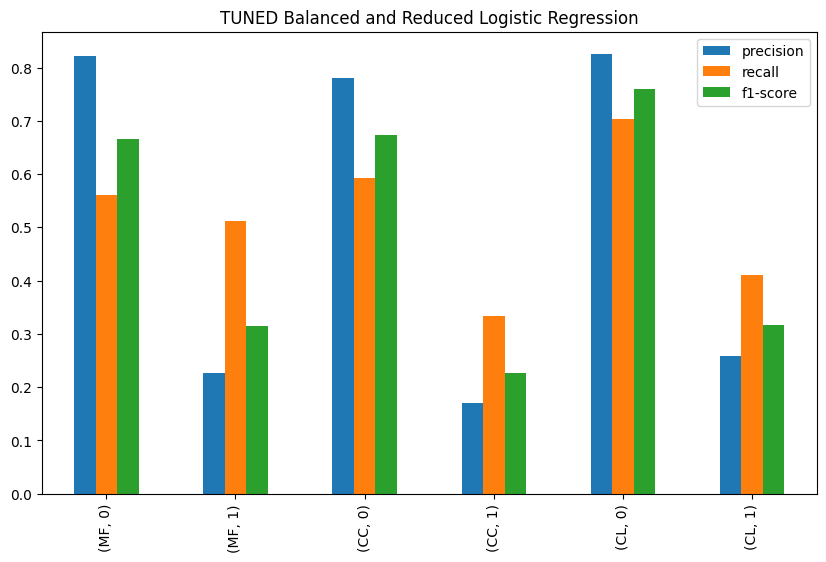

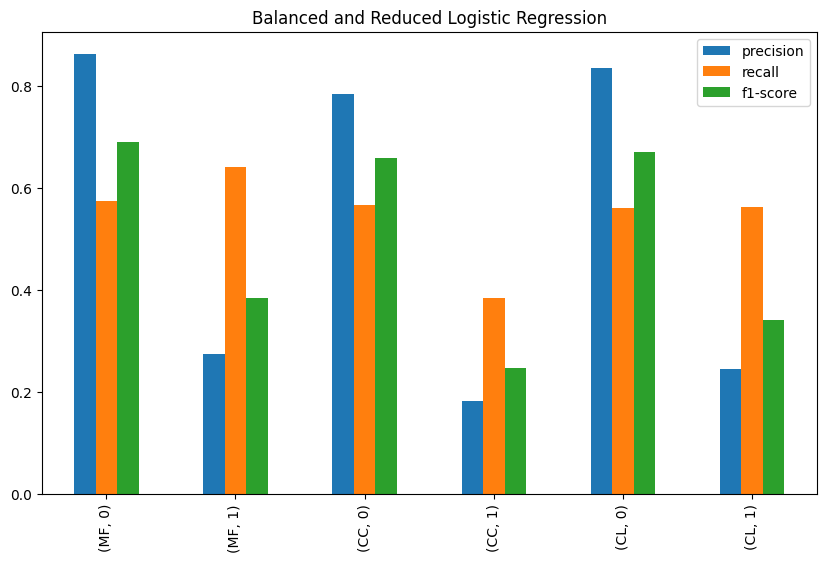

In [10]:
cutoff = 0.5
# for cutoff in [0.5,0.45,0.4,0.35,0.3,0.25,0.2]:

# evaluate Logistic Regression on full features without balancing
lr_mf_t, lr_mf_data_t, lr_mf_feats_t = evaluate_lr(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=False, reduced=False, tune=True)
lr_mf, lr_mf_data, lr_mf_feats = evaluate_lr(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=False, reduced=False, tune=False)

lr_cc_t, lr_cc_data_t, lr_cc_feats_t = evaluate_lr(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=False, reduced=False, tune=True)
lr_cc, lr_cc_data, lr_cc_feats = evaluate_lr(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=False, reduced=False, tune=False)

lr_cl_t, lr_cl_data_t, lr_cl_feats_t = evaluate_lr(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=False, reduced=False, tune=True)
lr_cl, lr_cl_data, lr_cl_feats = evaluate_lr(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=False, reduced=False, tune=False)
all_lr_data_t = pd.concat(
    {   'MF': lr_mf_data_t,
        'CC': lr_cc_data_t,
        'CL': lr_cl_data_t}, axis=1)

ax = all_lr_data_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Logistic Regression')

all_lr_data = pd.concat(
    {   'MF': lr_mf_data,
        'CC': lr_cc_data,
        'CL': lr_cl_data}, axis=1)

ax = all_lr_data.T.plot(kind='bar', figsize=(10,6), title='Logistic Regression')

# evaluate Logistic Regression on full features with balancing
lr_mf_bal_t, lr_mf_data_bal_t, lr_mf_feats_bal_t = evaluate_lr(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=True, reduced=False, tune=True)
lr_mf_bal, lr_mf_data_bal, lr_mf_feats_bal = evaluate_lr(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=True, reduced=False, tune=False)

lr_cc_bal_t, lr_cc_data_bal_t, lr_cc_feats_bal_t = evaluate_lr(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=True, reduced=False, tune=True)
lr_cc_bal, lr_cc_data_bal, lr_cc_feats_bal = evaluate_lr(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=True, reduced=False, tune=False)

lr_cl_bal_t, lr_cl_data_bal_t, lr_cl_feats_bal_t = evaluate_lr(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=True, reduced=False, tune=True)
lr_cl_bal, lr_cl_data_bal, lr_cl_feats_bal = evaluate_lr(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=True, reduced=False, tune=False)

all_lr_data_bal_t = pd.concat(
    {   'MF': lr_mf_data_bal_t,
        'CC': lr_cc_data_bal_t,
        'CL': lr_cl_data_bal_t}, axis=1)

ax = all_lr_data_bal_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Balanced Logistic Regression')

all_lr_data_bal = pd.concat(
    {   'MF': lr_mf_data_bal,
        'CC': lr_cc_data_bal,
        'CL': lr_cl_data_bal}, axis=1)

ax = all_lr_data_bal.T.plot(kind='bar', figsize=(10,6), title='Balanced Logistic Regression')

# # evaluate Logistic Regression on reduced features without balancing
lr_mf_reduced_t, lr_mf_data_reduced_t, lr_mf_feats_reduced_t, X_te_reduced_mf_t = reduced_features(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", lr_mf_feats_t, cutoff, balance=False, tune=True)
lr_mf_reduced, lr_mf_data_reduced, lr_mf_feats_reduced, X_te_reduced_mf = reduced_features(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", lr_mf_feats, cutoff, balance=False, tune=False)

lr_cc_reduced_t, lr_cc_data_reduced_t, lr_cc_feats_reduced_t, X_te_reduced_cc_t = reduced_features(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", lr_cc_feats_t, cutoff, balance=False, tune=True)
lr_cc_reduced, lr_cc_data_reduced, lr_cc_feats_reduced, X_te_reduced_cc = reduced_features(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", lr_cc_feats, cutoff, balance=False, tune=False)

lr_cl_reduced_t, lr_cl_data_reduced_t, lr_cl_feats_reduced_t, X_te_reduced_cl_t = reduced_features(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", lr_cl_feats_t, cutoff, balance=False, tune=True)
lr_cl_reduced, lr_cl_data_reduced, lr_cl_feats_reduced, X_te_reduced_cl = reduced_features(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", lr_cl_feats, cutoff, balance=False, tune=False)

all_lr_data_reduced_t = pd.concat(
    {   'MF': lr_mf_data_reduced_t,
        'CC': lr_cc_data_reduced_t,
        'CL': lr_cl_data_reduced_t}, axis=1)

ax = all_lr_data_reduced_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Reduced Logistic Regression')

all_lr_data_reduced = pd.concat(
    {   'MF': lr_mf_data_reduced,
        'CC': lr_cc_data_reduced,
        'CL': lr_cl_data_reduced}, axis=1)

ax = all_lr_data_reduced.T.plot(kind='bar', figsize=(10,6), title='Reduced Logistic Regression')

# evaluate Logistic Regression on reduced features with balancing
lr_mf_reduced_b_t, lr_mf_data_reduced_b_t, lr_mf_feats_reduced_b_t, X_te_reduced_mf_b_t = reduced_features(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", lr_mf_feats_bal_t, cutoff, balance=True, tune=True)
lr_mf_reduced_b, lr_mf_data_reduced_b, lr_mf_feats_reduced_b, X_te_reduced_mf_b = reduced_features(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", lr_mf_feats_bal, cutoff, balance=True, tune=False)

lr_cc_reduced_b_t, lr_cc_data_reduced_b_t, lr_cc_feats_reduced_b_t, X_te_reduced_cc_b_t = reduced_features(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", lr_cc_feats_bal_t, cutoff, balance=True, tune=True)
lr_cc_reduced_b, lr_cc_data_reduced_b, lr_cc_feats_reduced_b, X_te_reduced_cc_b = reduced_features(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", lr_cc_feats_bal, cutoff, balance=True, tune=False)

lr_cl_reduced_b_t, lr_cl_data_reduced_b_t, lr_cl_feats_reduced_b_t, X_te_reduced_cl_b_t = reduced_features(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", lr_cl_feats_bal_t, cutoff, balance=True, tune=True)
lr_cl_reduced_b, lr_cl_data_reduced_b, lr_cl_feats_reduced_b, X_te_reduced_cl_b = reduced_features(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", lr_cl_feats_bal, cutoff, balance=True, tune=False)

all_lr_data_reduced_b_t = pd.concat(
    {   'MF': lr_mf_data_reduced_b_t,
        'CC': lr_cc_data_reduced_b_t,
        'CL': lr_cl_data_reduced_b_t}, axis=1)

ax = all_lr_data_reduced_b_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Balanced and Reduced Logistic Regression')

all_lr_data_reduced_b = pd.concat(
    {   'MF': lr_mf_data_reduced_b,
        'CC': lr_cc_data_reduced_b,
        'CL': lr_cl_data_reduced_b}, axis=1)

ax = all_lr_data_reduced_b.T.plot(kind='bar', figsize=(10,6), title='Balanced and Reduced Logistic Regression')


### random forest classifier

In [11]:
def tune_rfc_params(X_tr, y_tr, balance, n_iter=50, cv_folds=5):
    """
    Runs RandomizedSearchCV to find best hyperparameters for a RandomForestClassifier.
    
    Parameters:
    - X_tr, y_tr: training data
    - balance: bool, whether to include class_weight='balanced'
    - n_iter: number of random settings to try
    - cv_folds: number of CV folds
    
    Returns:
    - best_params: dict of best parameters (ready for RFC constructor)
    """
    # pipeline wraps scaling + RFC
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("clf", RandomForestClassifier(random_state=42,
                                        class_weight='balanced' if balance else None))
    ])
    # param distributions
    param_dist = {
        "clf__n_estimators":    randint(100, 1000),
        "clf__max_features":    ["auto", "sqrt", "log2", None],
        "clf__max_depth":       randint(3, 20),
        "clf__min_samples_split": randint(2, 20),
        "clf__min_samples_leaf":  randint(1, 20),
        "clf__bootstrap":       [True, False]
    }
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring="precision",
        cv=StratifiedKFold(cv_folds, shuffle=True, random_state=42),
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_tr, y_tr)
    best = {
        key.replace("clf__", ""): val
        for key, val in search.best_params_.items()
    }
    return best, search.best_score_

In [12]:
def evaluate_rfc(X_tr, y_tr, X_te, y_te, label_name, cutoff, balance, reduced, tune, sel_feats=False):
    """
    Evaluates a Random Forest Classifier on the provided training and testing data.
    Parameters:
    - X_tr: Training features
    - y_tr: Training labels
    - X_te: Testing features
    - y_te: Testing labels
    - label_name: Name of the product label for reporting
    - cutoff: Probability threshold for classification
    - balance: Boolean indicating whether to balance the classes
    - reduced: Boolean indicating whether to use reduced features
    - tune: Boolean indicating whether to tune hyperparameters
    Returns:
    - rfc: The fitted Random Forest Classifier
    - rfc_data: DataFrame containing precision, recall, and f1-score for each class
    - sel: The selected features
    """

    if tune:
        best_params, best_score = tune_rfc_params(X_tr, y_tr, balance)
        print(f"Best RFC params: {best_params}, score={best_score:.3f}")
    else:
        best_params = {}

    # fit and predict
    rfc_full = RandomForestClassifier(
        n_estimators=best_params.get("n_estimators", 200),
        max_features=best_params.get("max_features", None),
        max_depth=best_params.get("max_depth", None),
        min_samples_split=best_params.get("min_samples_split", 2),
        min_samples_leaf=best_params.get("min_samples_leaf", 1),
        bootstrap=best_params.get("bootstrap", True),
        random_state=42,
        class_weight='balanced' if balance else None
    )
    rfc_full.fit(X_tr, y_tr)

    if reduced:
        sel = SelectFromModel(rfc_full, threshold="0.5*mean", prefit=True)
        keep = X_tr.columns[sel.get_support()]
        
        X_tr_red = sel.transform(X_tr)
        X_te_red = sel.transform(X_te)
        
        rfc = RandomForestClassifier(
            n_estimators=best_params.get("n_estimators", 200),
            max_features=best_params.get("max_features", None),
            max_depth=best_params.get("max_depth", None),
            min_samples_split=best_params.get("min_samples_split", 2),
            min_samples_leaf=best_params.get("min_samples_leaf", 1),
            bootstrap=best_params.get("bootstrap", True),
            random_state=42,
            class_weight='balanced' if balance else None
        )
        rfc.fit(X_tr_red, y_tr)

        proba_pos = rfc.predict_proba(X_te_red)[:, 1]
    else:
        rfc = rfc_full
        proba_pos = rfc.predict_proba(X_te)[:, 1]

    y_pred = (proba_pos >= cutoff).astype(int)

    mode = "BALANCED" if balance else "UNBALANCED"
    size = "REDUCED"  if reduced else "FULL"
    print(f"\n{size} FEATURES AND {mode} RFC {label_name} with CUTOFF {cutoff}:")
    
    print(classification_report(y_te, y_pred, digits=4))
    rfc_data = classification_report(y_te, y_pred, digits=4, output_dict=True)
    rfc_data = pd.DataFrame(rfc_data).loc[['precision', 'recall', 'f1-score'], ['0', '1']]

    ap = average_precision_score(y_te, proba_pos)
    print(f"\n P-R AUC for {size} FEATURES AND {mode} RFC {label_name} with CUTOFF {cutoff}: {ap:.4f}") 
    plot_confusion_matrix(y_te, y_pred, label_name)
  
    # feature importance
    if reduced:
        imp = pd.Series(rfc.feature_importances_, index=keep).sort_values(ascending=False)
    else:
        imp = pd.Series(rfc.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    
    imp.plot.barh(figsize=(6,8))
    plt.xlabel("Importance")
    if reduced: plt.title("Reduced RFC Features" + f" for {label_name}")
    else: plt.title("RFC Features" + f" for {label_name}")
    plt.gca().invert_yaxis()
    plt.show()

    if sel_feats: return rfc, rfc_data, sel
    else: return rfc, rfc_data

the following 4 cells below were commented out since LR performed better (had higher PRECISION)

In [13]:
# # Evaluate Random Forest Classifier on full features without balancing
# cutoff=0.5
# # for cutoff in [0.4,0.35,0.3,0.25,0.2]:

# rfc_mf_t, rfc_mf_data_t = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=False, reduced=False, tune=True)
# rfc_mf, rfc_mf_data = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=False, reduced=False, tune=False)

# rfc_cc_t, rfc_cc_data_t = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=False, reduced=False, tune=True)
# rfc_cc, rfc_cc_data = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=False, reduced=False, tune=False)

# rfc_cl_t, rfc_cl_data_t = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=False, reduced=False, tune=True)
# rfc_cl, rfc_cl_data = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=False, reduced=False, tune=False)

# # plot_pr_curve(rfc_mf_t, X_test_mf, y_test_mf)
# all_rfc_data_t = pd.concat(
#     {   'MF': rfc_mf_data_t,
#         'CC': rfc_cc_data_t,
#         'CL': rfc_cl_data_t}, axis=1)
# ax = all_rfc_data_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Random Forest Classifier', grid=True)

# # plot_pr_curve(rfc_mf, X_test_mf, y_test_mf)
# all_rfc_data = pd.concat(
#     {   'MF': rfc_mf_data,
#         'CC': rfc_cc_data,
#         'CL': rfc_cl_data}, axis=1)
# ax = all_rfc_data.T.plot(kind='bar', figsize=(10,6), title='Random Forest Classifier', grid=True)

In [14]:
# # Evaluate Random Forest Classifier on full features with balancing
# rfc_mf_balanced_t, rfc_mf_data_bal_t = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=True, reduced=False, tune=True)
# rfc_mf_balanced, rfc_mf_data_bal = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=True, reduced=False, tune=False)
# rfc_cc_balanced_t, rfc_cc_data_bal_t = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=True, reduced=False, tune=True)
# rfc_cc_balanced, rfc_cc_data_bal = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=True, reduced=False, tune=False)

# rfc_cl_balanced_t, rfc_cl_data_bal_t = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=True, reduced=False, tune=True)
# rfc_cl_balanced, rfc_cl_data_bal = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=True, reduced=False, tune=False)

# # plot_pr_curve(rfc_mf_balanced_t, X_test_mf, y_test_mf)
# all_rfc_data_bal_t = pd.concat(
#     {   'MF': rfc_mf_data_bal_t,
#         'CC': rfc_cc_data_bal_t,
#         'CL': rfc_cl_data_bal_t}, axis=1)
# ax = all_rfc_data_bal_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Balanced Random Forest Classifier', grid=True)

# # plot_pr_curve(rfc_mf_balanced, X_test_mf, y_test_mf)
# all_rfc_data_bal = pd.concat(
#     {   'MF': rfc_mf_data_bal,  
#         'CC': rfc_cc_data_bal,
#         'CL': rfc_cl_data_bal}, axis=1)
# ax = all_rfc_data_bal.T.plot(kind='bar', figsize=(10,6), title='Balanced Random Forest Classifier', grid=True)

In [15]:
# # Evaluate Random Forest Classifier on reduced features without balancing
# rfc_mf_reduced_t, rfc_mf_data_reduced_t = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=False, reduced=True, tune=True)
# rfc_mf_reduced, rfc_mf_data_reduced = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=False, reduced=True, tune=False)

# rfc_cc_reduced_t, rfc_cc_data_reduced_t = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=False, reduced=True, tune=True)
# rfc_cc_reduced, rfc_cc_data_reduced = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=False, reduced=True, tune=False)

# rfc_cl_reduced_t, rfc_cl_data_reduced_t = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=False, reduced=True, tune=True)
# rfc_cl_reduced, rfc_cl_data_reduced = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=False, reduced=True, tune=False)

# # plot_pr_curve(rfc_mf_reduced_t, X_te_reduced_mf, y_test_mf)
# all_rfc_data_reduced_t = pd.concat(
#     {   'MF': rfc_mf_data_reduced_t,
#         'CC': rfc_cc_data_reduced_t,
#         'CL': rfc_cl_data_reduced_t}, axis=1)
# ax = all_rfc_data_reduced_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Reduced Random Forest Classifier', grid=True)

# # plot_pr_curve(rfc_mf_reduced, X_te_reduced_mf, y_test_mf)
# all_rfc_data_reduced = pd.concat(
#     {   'MF': rfc_mf_data_reduced,
#         'CC': rfc_cc_data_reduced,
#         'CL': rfc_cl_data_reduced}, axis=1)
# ax = all_rfc_data_reduced.T.plot(kind='bar', figsize=(10,6), title='Reduced Random Forest Classifier', grid=True)

In [16]:
# # Evaluate Random Forest Classifier on reduced features with balancing
# rfc_mf_reduced_b_t, rfc_mf_data_reduced_b_t = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=True, reduced=True, tune=True)
# rfc_mf_reduced_b, rfc_mf_data_reduced_b = evaluate_rfc(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=True, reduced=True, tune=False)
# rfc_cc_reduced_b_t, rfc_cc_data_reduced_b_t = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=True, reduced=True, tune=True)
# rfc_cc_reduced_b, rfc_cc_data_reduced_b = evaluate_rfc(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=True, reduced=True, tune=False)

# rfc_cl_reduced_b_t, rfc_cl_data_reduced_b_t = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=True, reduced=True, tune=True)
# rfc_cl_reduced_b, rfc_cl_data_reduced_b = evaluate_rfc(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=True, reduced=True, tune=False)


# # plot_pr_curve(rfc_mf_reduced_b_t, X_te_reduced_mf_b, y_test_mf)
# all_rfc_data_reduced_b_t = pd.concat(
#     {   'MF': rfc_mf_data_reduced_b_t,
#         'CC': rfc_cc_data_reduced_b_t,
#         'CL': rfc_cl_data_reduced_b_t}, axis=1)
# ax = all_rfc_data_reduced_b_t.T.plot(kind='bar', figsize=(10,6), title='TUNED Balanced and Reduced Random Forest Classifier', grid=True)

# # plot_pr_curve(rfc_mf_reduced_b, X_te_reduced_mf_b, y_test_mf)
# all_rfc_data_reduced_b = pd.concat(
#     {   'MF': rfc_mf_data_reduced_b,
#         'CC': rfc_cc_data_reduced_b,
#         'CL': rfc_cl_data_reduced_b}, axis=1)

# ax = all_rfc_data_reduced_b.T.plot(kind='bar', figsize=(10,6), title='Balanced and Reduced Random Forest Classifier', grid=True)

### final models for precision <br>
logistic regression models appeared to have a higher precision than random forest classifier models. comparisons were done with tuned/arbitrary hyperparameters, balanced/unbalance class weights, and reduced/full features. scoring of hyperparameter tuning was set to precision.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\jed jerrel escaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Tuned LR params: {'C': 1.7718847354806815, 'max_iter': 10, 'penalty': 'l2'}, CV precision=0.638

FULL FEATURES AND UNBALANCED LR MF with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.8128    0.9806    0.8889       155
           1     0.5714    0.1026    0.1739        39

    accuracy                         0.8041       194
   macro avg     0.6921    0.5416    0.5314       194
weighted avg     0.7643    0.8041    0.7452       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR MF with CUTOFF 0.5: 0.3083


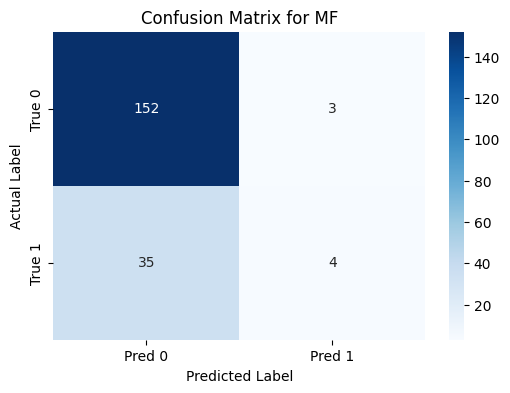

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.14081468939305825, 'max_iter': 100, 'penalty': 'l2'}, CV precision=0.601

FULL FEATURES AND UNBALANCED LR CC with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7772    0.9862    0.8693       145
           1     0.8000    0.1633    0.2712        49

    accuracy                         0.7784       194
   macro avg     0.7886    0.5747    0.5702       194
weighted avg     0.7829    0.7784    0.7182       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR CC with CUTOFF 0.5: 0.5388


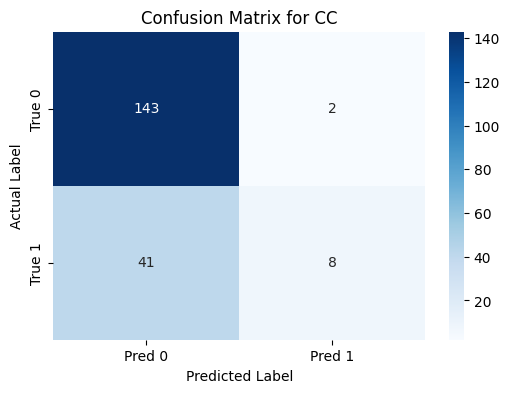

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuned LR params: {'C': 0.04731474644815004, 'max_iter': 100, 'penalty': 'l2'}, CV precision=0.728

FULL FEATURES AND UNBALANCED LR CL with CUTOFF 0.5:
              precision    recall  f1-score   support

           0     0.7308    0.9779    0.8365       136
           1     0.7500    0.1552    0.2571        58

    accuracy                         0.7320       194
   macro avg     0.7404    0.5666    0.5468       194
weighted avg     0.7365    0.7320    0.6633       194


 P-R AUC for FULL FEATURES AND UNBALANCED LR CL with CUTOFF 0.5: 0.4974


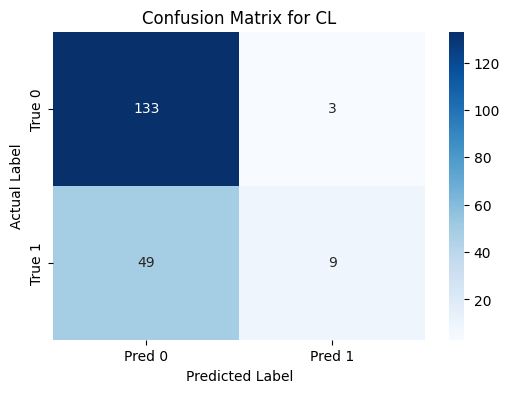

In [17]:
cutoff=0.5
mf_precision_T, lr_mf_data_t, lr_mf_feats_t = evaluate_lr(X_train_mf, y_train_mf, X_test_mf, y_test_mf, "MF", cutoff, balance=False, reduced=False, tune=True)
cc_precision_T, lr_cc_data_t, lr_cc_feats_t = evaluate_lr(X_train_cc, y_train_cc, X_test_cc, y_test_cc, "CC", cutoff, balance=False, reduced=False, tune=True)
cl_precision_T, lr_cl_data_t, lr_cl_feats_t = evaluate_lr(X_train_cl, y_train_cl, X_test_cl, y_test_cl, "CL", cutoff, balance=False, reduced=False, tune=True)


              precision    recall  f1-score   support

           0       0.81      0.96      0.88       155
           1       0.45      0.13      0.20        39

    accuracy                           0.79       194
   macro avg       0.63      0.54      0.54       194
weighted avg       0.74      0.79      0.74       194



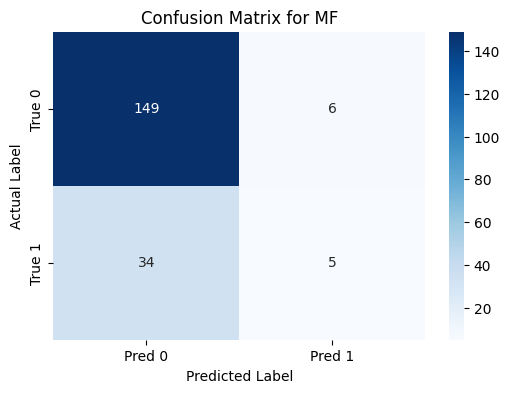

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       146
           1       0.67      0.12      0.21        48

    accuracy                           0.77       194
   macro avg       0.72      0.55      0.54       194
weighted avg       0.75      0.77      0.70       194



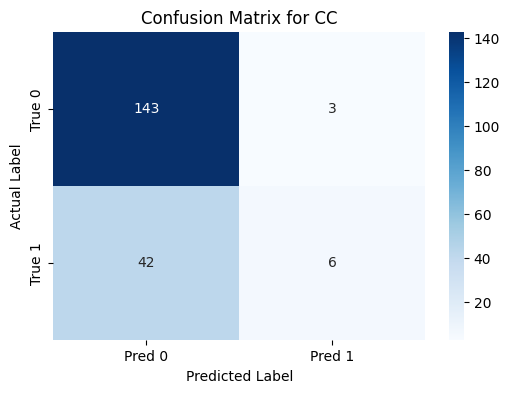

              precision    recall  f1-score   support

           0       0.74      0.95      0.83       136
           1       0.63      0.21      0.31        58

    accuracy                           0.73       194
   macro avg       0.68      0.58      0.57       194
weighted avg       0.71      0.73      0.67       194



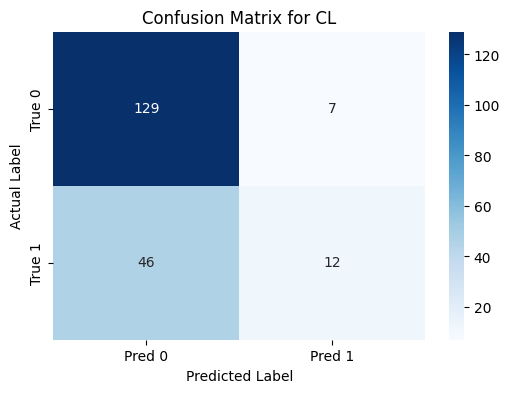

In [18]:
def predicting_unlabeled_dataset(model,dataset,label,cutoff=0.5,print=False):
    proba_pos = model.predict_proba(dataset)
    y_pred = (proba_pos >= cutoff).astype(int)
    final_pred = pd.DataFrame(proba_pos, columns=['prob_0', 'prob_1'], index=dataset.index) 
    final_pred['product']=label
    final_pred.drop(columns='prob_0', inplace=True)
    if print: print(final_pred)
    return y_pred, final_pred

# final testing on validation set before predicting the unlabeled dataset
predproba_mf, mf_predictions = predicting_unlabeled_dataset(mf_precision_T,X_finaltest_mf,'MF')
print(classification_report(y_finaltest_mf, predproba_mf[:,1]))
plot_confusion_matrix(y_finaltest_mf, predproba_mf[:,1], "MF")

predproba_cc, cc_predictions = predicting_unlabeled_dataset(cc_precision_T,X_finaltest_cc,'CC')
print(classification_report(y_finaltest_cc, predproba_cc[:,1]))
plot_confusion_matrix(y_finaltest_cc, predproba_cc[:,1], "CC")

predproba_cl, cl_predictions = predicting_unlabeled_dataset(cl_precision_T,X_finaltest_cl,'CL')
print(classification_report(y_finaltest_cl, predproba_cl[:,1]))
plot_confusion_matrix(y_finaltest_cl, predproba_cl[:,1], "CL")


### predicting 40% unlabeled data <br>

In [19]:
client_pred_mf, client_proba_mf = predicting_unlabeled_dataset(mf_precision_T,features_unlabeled,'MF')
client_pred_cc, client_proba_cc = predicting_unlabeled_dataset(cc_precision_T,features_unlabeled,'CC')
client_pred_cl, client_proba_cl = predicting_unlabeled_dataset(cl_precision_T,features_unlabeled,'CL')

all_predictions = pd.concat([client_proba_mf,client_proba_cc,client_proba_cl], axis=0)
all_predictions.sort_values(by='prob_1',ascending=False,inplace=True)
all_predictions = all_predictions[~all_predictions.index.duplicated(keep="first")]
print("how many clients to be offered which product?:")
print(all_predictions["product"].value_counts())

print("\ntop 100 likely buyers")
top_potential_buyers = all_predictions[:100]
print(top_potential_buyers)

counts = top_potential_buyers["product"].value_counts()
print("\nproducts the top 100 are to be offered:")
print(counts)

how many clients to be offered which product?:
product
CL    302
CC    203
MF    141
Name: count, dtype: int64

top 100 likely buyers
          prob_1 product
Client                  
506     0.999747      MF
1414    0.999690      CC
1077    0.997296      CC
1455    0.994288      CC
766     0.982818      MF
...          ...     ...
940     0.524211      MF
1093    0.517859      MF
1119    0.517334      CL
710     0.515998      CL
1148    0.511020      MF

[100 rows x 2 columns]

products the top 100 are to be offered:
product
CL    43
MF    33
CC    24
Name: count, dtype: int64


from our predictions, the top 100 highest probability buyers are composed of 43 CL buyers, 33 MF buyers, and 24 CC buyers. their likelihood of availing a product ranges from 0.51 to 0.99.

## models for revenue

In [20]:
nonzero_mf = Sales_Revenues['Revenue_MF'] > 0
nonzero_cc = Sales_Revenues['Revenue_CC'] > 0
nonzero_cl = Sales_Revenues['Revenue_CL'] > 0

# for revenue predicting, features_mf for revenue_mf
revfeatures_mf = features[nonzero_mf]
revtarget_mf = Sales_Revenues.loc[nonzero_mf, 'Revenue_MF']
revfeatures_cc = features[nonzero_cc]
revtarget_cc = Sales_Revenues.loc[nonzero_cc, 'Revenue_CC']
revfeatures_cl = features[nonzero_cl]
revtarget_cl = Sales_Revenues.loc[nonzero_cl, 'Revenue_CL']

In [21]:
def split_train_test(features,targets,label):

    X_train, X_test, y_train, y_test = train_test_split(
        features, targets, 
        test_size=0.2, random_state=42
        )
    p = X_train.shape[1]
    rfc = RandomForestRegressor(
        n_estimators=500,
        max_features= max(1, p//3),  
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42
    )

    rfc.fit(X_train,y_train)
    y_pred = rfc.predict(X_test)
    rmse = root_mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)
    r2train = r2_score(y_train, rfc.predict(X_train))
    print(f'\nmodel for {label}')
    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R²:   {r2:.3f}")
    return rfc

# models for mf, cc, and cl
rev_model_mf = split_train_test(revfeatures_mf,revtarget_mf,'MF')
rev_model_cc = split_train_test(revfeatures_cc,revtarget_cc,'CC')
rev_model_cl = split_train_test(revfeatures_cl,revtarget_cl,'CL')




model for MF
Test RMSE: 18.068
Test R²:   -0.091

model for CC
Test RMSE: 20.980
Test R²:   -0.280

model for CL
Test RMSE: 6.670
Test R²:   -0.172


In [22]:
# in the top 100 buyers for each product
top_potential_buyers_mf = top_potential_buyers[top_potential_buyers['product'] == 'MF']
top_potential_buyers_cc = top_potential_buyers[top_potential_buyers['product'] == 'CC']
top_potential_buyers_cl = top_potential_buyers[top_potential_buyers['product'] == 'CL']

# for predicting revenue
def pred_rev(model,dataset): 
    y_pred = model.predict(dataset)
    y_pred = pd.DataFrame(y_pred, columns=['predicted revenue'], index=dataset.index)
    return y_pred

# predicted revenue for all potential clients for each product
pred_rev_mf = pred_rev(rev_model_mf,features_unlabeled)
pred_rev_cc = pred_rev(rev_model_cc,features_unlabeled)
pred_rev_cl = pred_rev(rev_model_cl,features_unlabeled)
 
# proba + rev 
clients_likelihood_and_rev_mf = pd.concat([top_potential_buyers_mf,pred_rev_mf.loc[top_potential_buyers_mf.index]],axis=1)
clients_likelihood_and_rev_cc = pd.concat([top_potential_buyers_cc,pred_rev_cc.loc[top_potential_buyers_cc.index]],axis=1)
clients_likelihood_and_rev_cl = pd.concat([top_potential_buyers_cl,pred_rev_cl.loc[top_potential_buyers_cl.index]],axis=1)

# proba + rev of all products
top_clients_likelihood_and_rev = pd.concat([clients_likelihood_and_rev_mf,clients_likelihood_and_rev_cc,clients_likelihood_and_rev_cl],axis=0)
top_clients_likelihood_and_rev.sort_values(by='prob_1', ascending=False, inplace=True)

# expected revenue
top_clients_likelihood_and_rev['expected revenue'] = top_clients_likelihood_and_rev['prob_1'] * top_clients_likelihood_and_rev['predicted revenue'] 
print('the expected revenue (probability x predicted revenue) for the top 100 likely buyers:')
print(top_clients_likelihood_and_rev['expected revenue'].sum())

print('\nthe total maximum revenue for the top 100 likely buyers:')
print(top_clients_likelihood_and_rev['predicted revenue'].sum())

the expected revenue (probability x predicted revenue) for the top 100 likely buyers:
796.1091425671053

the total maximum revenue for the top 100 likely buyers:
1192.479626699915


In [23]:
top_clients_likelihood_and_rev

,prob_1,product,predicted revenue,expected revenue
Client,,,,
506,0.999747,MF,15.538361,15.534423
1414,0.999690,CC,13.633134,13.628904
1077,0.997296,CC,17.729156,17.681217
1455,0.994288,CC,14.495135,14.412339
766,0.982818,MF,18.326443,18.011552
...,...,...,...,...
940,0.524211,MF,10.646401,5.580964
1093,0.517859,MF,20.273788,10.498959
1119,0.517334,CL,12.727506,6.584373


#### above shows the "HIGHEST PROBABILITY LIST" or the top 100 clients which are most likely to avail one of the three products. the probabilities of these clients accepting the offer ranges from 0.99 to 0.51. if all of the 100 clients in the list avails the product offered, the predicted maximum revenue would be: €1192. the expected revenue is the weighed revenue which basically takes into account the probability of the buyer accepting the offer. the expected revenue is €796.

for the maximum potential revenue, we prioritize Expected Rrevenue instead of Likelihood to Purchase. refer below for the "HIGHEST REVENUE LIST":

In [24]:
# checking the probability for a buyer to accept an offer for each product, and the predicted revenue 
checking = pd.concat([client_proba_mf,pred_rev_mf,client_proba_cc,pred_rev_cc,client_proba_cl,pred_rev_cl], axis = 1)
checking


,prob_1,product,predicted revenue,prob_1,product,predicted revenue,prob_1,product,predicted revenue
Client,,,,,,,,,
3,0.314311,MF,8.161180,0.157976,CC,9.538301,0.391100,CL,11.981021
4,0.270590,MF,3.471086,0.165273,CC,15.970482,0.284544,CL,10.786519
5,0.253140,MF,4.201326,0.369959,CC,22.099499,0.582928,CL,11.102670
7,0.130760,MF,8.036400,0.240687,CC,10.585046,0.388953,CL,15.523177
9,0.059127,MF,6.398583,0.338177,CC,6.077243,0.420600,CL,12.475061
...,...,...,...,...,...,...,...,...,...
1606,0.345586,MF,5.099072,0.116873,CC,9.045770,0.215317,CL,12.574337
1609,0.202522,MF,12.647881,0.217107,CC,7.874120,0.285862,CL,9.583379
1610,0.221804,MF,14.395311,0.079442,CC,6.451783,0.235612,CL,12.555334


In [25]:
checking_exp_rev = pd.DataFrame({
    'MF':checking.iloc[:,0]*checking.iloc[:,2],
    'CC':checking.iloc[:,3]*checking.iloc[:,5],
    'CL':checking.iloc[:,6]*checking.iloc[:,8],
})
checking_exp_rev['max_revenue'] = checking_exp_rev[['MF','CC','CL']].idxmax(axis=1)
checking_exp_rev['max_rev_val'] = checking_exp_rev[['MF','CC','CL']].max(axis=1)
checking_exp_rev.sort_values(by='max_rev_val', ascending=False, inplace=True)

max_revenue_clients = checking_exp_rev[:100]
max_revenue_clients



,MF,CC,CL,max_revenue,max_rev_val
Client,,,,,
766,18.011552,0.026612,1.070456,MF,18.011552
1077,0.000773,17.681217,15.488150,CC,17.681217
1278,0.124875,17.332813,1.630403,CC,17.332813
506,15.534423,0.004082,1.117251,MF,15.534423
1289,0.002292,15.324700,9.725850,CC,15.324700
...,...,...,...,...,...
1343,0.651124,1.297970,6.814025,CL,6.814025
1242,0.211902,6.774899,4.903605,CC,6.774899
1026,3.650623,6.758515,1.499096,CC,6.758515


In [26]:
# clients present in both the highest probability and highest revenue list
common_clients = max_revenue_clients.index.intersection(top_clients_likelihood_and_rev.index)
print(common_clients.shape)

(65,)


In [27]:
proba_wide = pd.concat([
    client_proba_mf['prob_1'].rename('MF'),
    client_proba_cc['prob_1'].rename('CC'),
    client_proba_cl['prob_1'].rename('CL'),
], axis=1)

# 2) restrict to just your top‑100 clients’ index
proba_wide = proba_wide.reindex(max_revenue_clients.index)

# 3) map the revenue‐category labels to column indices
col_idx = {'MF': 0, 'CC': 1, 'CL': 2}

# 4) turn into numpy and compute per‑row positions
arr       = proba_wide.to_numpy()
row_idx   = np.arange(len(proba_wide))
col_idx_full = max_revenue_clients['max_revenue'].map(col_idx).to_numpy()

# 5) assign back in one go on the original DataFrame
proba_wide.loc[:, 'max_rev_proba'] = arr[row_idx, col_idx_full]

# overwrite or create max_rev_proba in your subset
max_revenue_clients = max_revenue_clients.assign(
    max_rev_proba = proba_wide['max_rev_proba']
)
print('the expected revenue (probability x predicted revenue) for the top 100 max expected revenue buyers:')
print(max_revenue_clients['max_rev_val'].sum())

print('\nthe total maximum revenue for the top 100 max expected revenue buyers:')
print((max_revenue_clients['max_rev_val'] / max_revenue_clients['max_rev_proba']).sum())

max_revenue_clients

the expected revenue (probability x predicted revenue) for the top 100 max expected revenue buyers:
930.237864875152

the total maximum revenue for the top 100 max expected revenue buyers:
1864.6695393964205


,MF,CC,CL,max_revenue,max_rev_val,max_rev_proba
Client,,,,,,
766,18.011552,0.026612,1.070456,MF,18.011552,0.982818
1077,0.000773,17.681217,15.488150,CC,17.681217,0.997296
1278,0.124875,17.332813,1.630403,CC,17.332813,0.794550
506,15.534423,0.004082,1.117251,MF,15.534423,0.999747
1289,0.002292,15.324700,9.725850,CC,15.324700,0.879492
...,...,...,...,...,...,...
1343,0.651124,1.297970,6.814025,CL,6.814025,0.533100
1242,0.211902,6.774899,4.903605,CC,6.774899,0.283602
1026,3.650623,6.758515,1.499096,CC,6.758515,0.259167


#### above shows the "HIGHEST REVENUE LIST" or the top 100 clients which yields the highest Expected Revenue, at €930. the probabilities of these clients accepting the offer ranges from 0.99 to 0.20. if all 100 clients avail the product offered, the total revenue will be €1864.

## for presentation figures

In [28]:
for_screenshot = max_revenue_clients[['max_rev_proba',
                                      'max_revenue'                                   
                                      ]]
for_screenshot['predicted revenue'] = pd.DataFrame({'predicted revenue': max_revenue_clients['max_rev_val']/max_revenue_clients['max_rev_proba']})
# for_screenshot = for_screenshot.rename(columns={'max_rev_proba': 'Probability',
for_screenshot['expected revenue'] = for_screenshot['max_rev_proba'] * for_screenshot['predicted revenue']
for_screenshot = for_screenshot.rename(columns={'max_rev_proba':'proba_1',
                                                'max_revenue':'product',
                                                })
for_screenshot

C:\Users\jed jerrel escaran\AppData\Local\Temp\ipykernel_22104\2150724168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_screenshot['predicted revenue'] = pd.DataFrame({'predicted revenue': max_revenue_clients['max_rev_val']/max_revenue_clients['max_rev_proba']})
C:\Users\jed jerrel escaran\AppData\Local\Temp\ipykernel_22104\2150724168.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for_screenshot['expected revenue'] = for_screenshot['max_rev_proba'] * for_screenshot['predicted revenue']


,proba_1,product,predicted revenue,expected revenue
Client,,,,
766,0.982818,MF,18.326443,18.011552
1077,0.997296,CC,17.729156,17.681217
1278,0.794550,CC,21.814629,17.332813
506,0.999747,MF,15.538361,15.534423
1289,0.879492,CC,17.424485,15.324700
...,...,...,...,...
1343,0.533100,CL,12.781885,6.814025
1242,0.283602,CC,23.888789,6.774899
1026,0.259167,CC,26.077884,6.758515


C:\Users\jed jerrel escaran\AppData\Local\Temp\ipykernel_22104\543879539.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap_name)


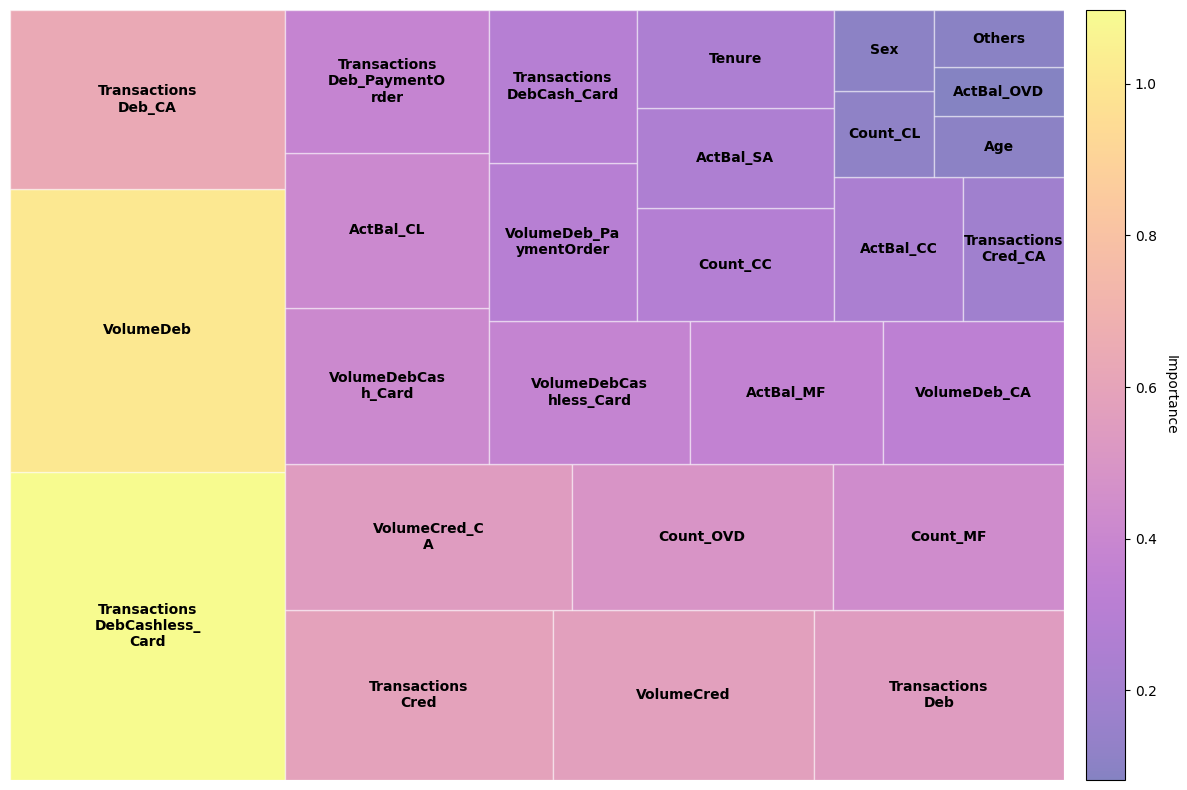

In [29]:
def plot_model_importance_treemap_with_legend(
    model,
    feature_names,
    threshold=0.01,
    top_n=None,
    wrap_width=12,
    cmap_name="plasma"
):
    """
    Plot a treemap of feature importances for tree models or absolute coefficients for linear models,
    and add a colorbar legend.

    Returns the list of major feature names (excluding 'Others').
    """
    # 1) Extract raw importances
    if hasattr(model, "feature_importances_"):
        raw_imp = model.feature_importances_
    else:
        # assume it's a Pipeline with a 'clf' step or a linear estimator directly
        try:
            lr = model.named_steps["clf"]
        except Exception:
            lr = model
        # coef_ might be shape (1, n_features) or (n_classes, n_features)
        coef = lr.coef_
        if coef.ndim > 1:
            # for multiclass, take mean absolute across classes
            raw_imp = np.abs(coef).mean(axis=0)
        else:
            raw_imp = np.abs(coef).ravel()

    # 2) Build DataFrame of importances
    df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': raw_imp
    }).sort_values(by='Importance', ascending=False)

    # 3) Split into major/minor
    if top_n is not None:
        major = df.head(top_n).copy()
        minor = df.iloc[top_n:]
    else:
        major = df[df['Importance'] >= threshold].copy()
        minor = df[df['Importance'] < threshold]

    # 4) Group minor features into 'Others'
    if not minor.empty:
        others_sum = minor['Importance'].sum()
        major = pd.concat([
            major,
            pd.DataFrame({'Feature': ['Others'], 'Importance': [others_sum]})
        ])

    # 5) Prepare labels (wrapped) and sizes
    labels = [textwrap.fill(f, wrap_width) for f in major['Feature']]
    sizes  = major['Importance'].tolist()

    # 6) Color normalization and colormap
    cmap = cm.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=major['Importance'].min(),
                                vmax=major['Importance'].max())
    colors = [cmap(norm(val)) for val in major['Importance']]

    # 7) Create figure & treemap
    fig, ax = plt.subplots(figsize=(12, 8))
    squarify.plot(
        sizes=sizes,
        label=labels,
        color=colors,
        alpha=0.5,
        edgecolor="white",
        linewidth=1,
        text_kwargs={'fontsize': 10, 'weight': 'bold'}
    )
    ax.axis('off')
    # plt.title('Model Feature Importances Treemap')

    # 8) Add colorbar legend
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.05, alpha=0.5,pad=0.02)
    cbar.set_label("Importance", rotation=270, labelpad=15)

    plt.tight_layout()
    plt.show()

    # 9) Return major feature list (excluding 'Others')
    return major.loc[major['Feature'] != 'Others', 'Feature'].tolist()


n_feats = plot_model_importance_treemap_with_legend(mf_precision_T, features_unlabeled.columns, top_n=26)


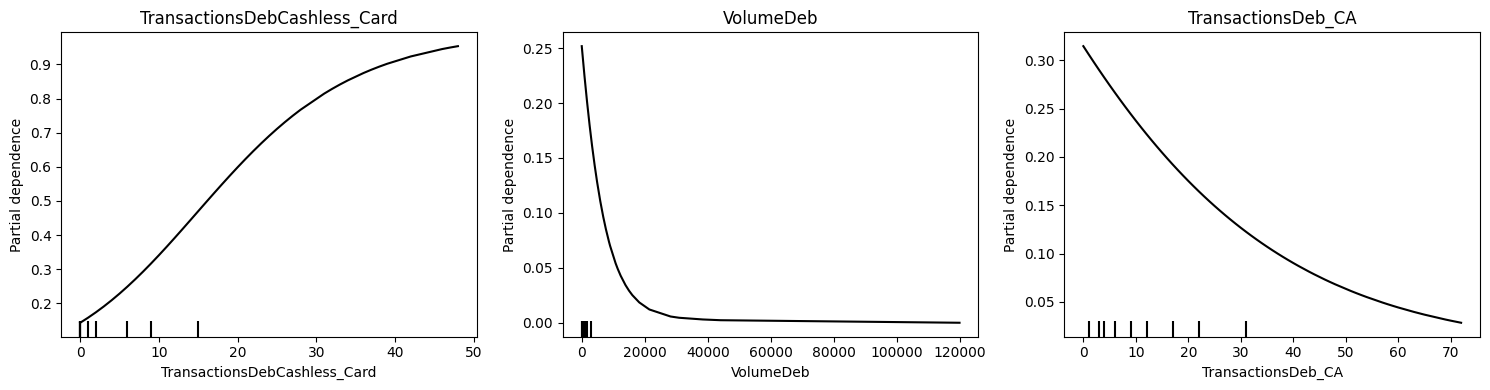

In [30]:
def plot_pdp(features_plot, model, X, rows=1, cols=3, grid_resolution=5000):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), sharey=False)
    axes = axes.flatten()
    
    for ax, feat in zip(axes, features_plot):
        # draw that single‐feature PDP onto its own ax
        PartialDependenceDisplay.from_estimator(
            model,
            X,
            [feat],
            ax=ax,
            kind="average",
            grid_resolution=grid_resolution,
            line_kw={"color": "black"}
        )
        ax.set_title(feat)
        ax.autoscale(enable=True, axis="y")  # force independent y-scaling

    # hide any unused subplots
    for ax in axes[len(features_plot):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

plot_pdp(n_feats,mf_precision_T,features_unlabeled)

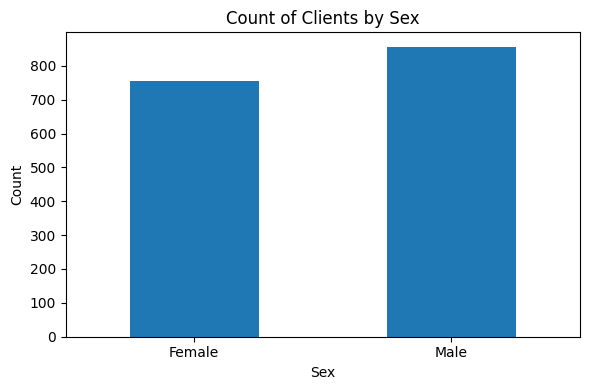

In [31]:
counts = soc_dem['Sex'].value_counts().sort_index()
counts.index = ['Female', 'Male'] 
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.title('Count of Clients by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

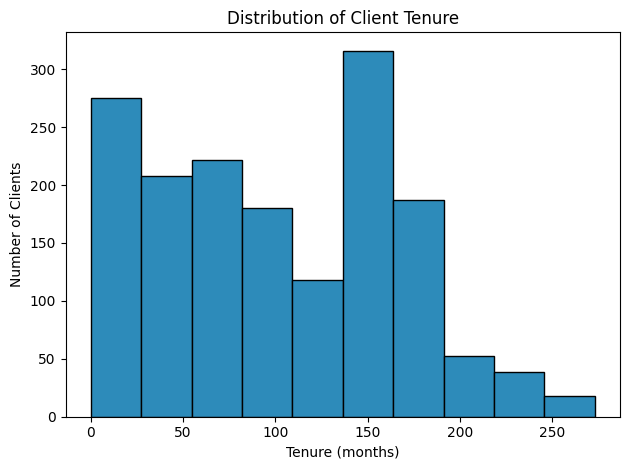

In [32]:
plt.hist(soc_dem['Tenure'],color='#2d8bba', ec='black')
plt.title('Distribution of Client Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Number of Clients')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

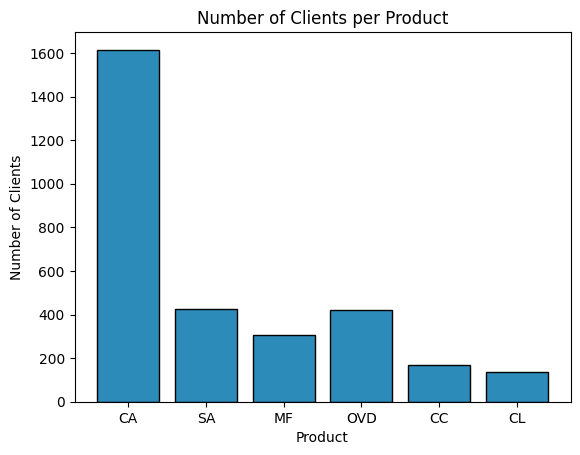

In [33]:
counts = {
    'CA': 1615,
    'SA':  426,
    'MF':  306,
    'OVD': 419,
    'CC':  170,
    'CL':  135}

plt.bar(counts.keys(), counts.values(),color='#2d8bba', ec='black')
plt.title('Number of Clients per Product')
plt.xlabel('Product')
plt.ylabel('Number of Clients')
plt.show()

In [34]:
# mf_precision_T.named_steps['clf'].coef_

coefs = mf_precision_T.named_steps['clf'].coef_[0]
coef_series = pd.Series(coefs, index=features_unlabeled.columns.tolist())
coef_series = coef_series.sort_values(key=abs, ascending=False)

print(coef_series)

TransactionsDebCashless_Card    1.096943
VolumeDeb                      -1.006640
TransactionsDeb_CA             -0.637064
TransactionsCred                0.586899
VolumeCred                      0.573114
TransactionsDeb                -0.548175
VolumeCred_CA                   0.542421
Count_OVD                      -0.493821
Count_MF                        0.437829
VolumeDebCash_Card             -0.411977
ActBal_CL                      -0.407954
TransactionsDeb_PaymentOrder    0.376437
VolumeDebCashless_Card         -0.372664
ActBal_MF                      -0.355889
VolumeDeb_CA                   -0.334415
VolumeDeb_PaymentOrder          0.302378
TransactionsDebCash_Card        0.292447
Count_CC                       -0.287411
ActBal_SA                      -0.255579
Tenure                         -0.250010
ActBal_CC                       0.239981
TransactionsCred_CA             0.187409
Count_CL                        0.112373
Sex                             0.104492
Age             

In [35]:
for_plotting_feats = pd.concat([data_without_sales,Sales_Revenues], axis = 1)
corr = for_plotting_feats.corr()
corr.sort_values(["Sale_CL"], ascending = False, inplace = True)
print(corr.Sale_CL)

Sale_CL                         1.000000
Revenue_CL                      0.712570
Tenure                          0.177345
TransactionsCred_CA             0.084753
Count_CA                        0.084619
TransactionsCred                0.083170
TransactionsDebCash_Card        0.075577
ActBal_MF                       0.074075
TransactionsDeb                 0.068233
ActBal_OVD                      0.067968
TransactionsDeb_CA              0.064502
VolumeDeb                       0.061492
Count_CL                        0.054304
ActBal_CL                       0.052295
VolumeDeb_PaymentOrder          0.051313
TransactionsDeb_PaymentOrder    0.048910
Count_MF                        0.045515
Count_OVD                       0.040541
VolumeDeb_CA                    0.039594
VolumeDebCashless_Card          0.036756
Count_SA                        0.036352
Revenue_MF                      0.015414
VolumeDebCash_Card              0.015153
TransactionsDebCashless_Card    0.014136
VolumeCred      